# 📊 Experiment Analysis: ML vs Baseline Healing & Intelligent test selection
This notebook compares healing effectiveness using post-healing and intelligent test selection dataset.


In [189]:
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency

## 1. Load both datasets

In [190]:

# Load datasets
df_all = pd.read_csv("all_logs.csv")
df_its = pd.read_csv("intelligent_test_selection.csv")

print("all_logs.csv:", df_all.shape)
print("intelligent_test_selection.csv:", df_its.shape)

# Quick peek
df_its.head()

all_logs.csv: (271, 10)
intelligent_test_selection.csv: (446, 10)


,timestamp,command,duration_s,exit_code,cpu_pct_avg,mem_kb_max,tag,status,pipeline_id,mode
0,2025-08-20 23:02:10,docker-login,0.5,0.0,0.00,0,build,pass,1995029365,baseline
1,2025-08-20 23:04:02,docker-build,1.5,0.0,6.73,39020,build,pass,1995029365,baseline
2,2025-08-20 23:04:19,docker-push,1.0,0.0,11.10,35180,build,pass,1995029365,baseline
3,2025-08-20 23:04:25,flake8 .,1.0,0.0,54.50,22224,lint,pass,1995029365,baseline
4,2025-08-20 23:04:31,python manage.py collectstatic --noinput,0.5,0.0,31.70,0,test,pass,1995029365,baseline


## 2. Harmonize schema

In [191]:
common_cols = set(df_all.columns) & set(df_its.columns)
df_all = df_all[list(common_cols)]
df_its = df_its[list(common_cols)]

## 3. Add a source label

In [192]:
df_all["phase"] = "pre_intelligent_selection_healing"
df_its["phase"] = "intelligent_selection"

df = pd.concat([df_all, df_its], ignore_index=True)

## 4. Compute per-pipeline aggregates

In [193]:
agg = (
    df.groupby(["phase", "pipeline_id"])
      .apply(lambda g: pd.Series({
          "minutes": g.loc[g["status"]!="skipped","duration_s"].sum()/60,
          "suites_run": (g["tag"].isin(["unit","functional"]) & (g["status"]!="skipped")).sum(),
          "suites_skipped": (g["tag"].isin(["unit","functional"]) & (g["status"]=="skipped")).sum(),
          "detected_fail": (g["status"]=="fail").any()
      }))
      .reset_index()
)

agg.head()

C:\Users\ehiva\AppData\Local\Temp\ipykernel_48172\3349125632.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,phase,pipeline_id,minutes,suites_run,suites_skipped,detected_fail
0,intelligent_selection,1995029365,0.200333,0,0,True
1,intelligent_selection,1997439219,0.150167,1,0,True
2,intelligent_selection,1997481162,0.217000,1,0,True
3,intelligent_selection,1997508403,0.158500,1,0,True
4,intelligent_selection,1997553750,0.133500,1,0,False


In [194]:
# See how many skip events exist
df[df["status"]=="skipped"]["tag"].value_counts()

tag
functional    21
unit           6
Name: count, dtype: int64

## 5. Compare metrics

Text(0.5, 1.0, 'Pipeline minutes executed by phase')

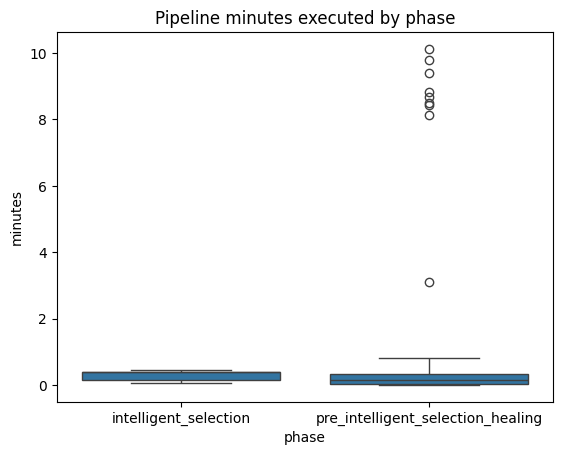

In [195]:
sns.boxplot(x="phase", y="minutes", data=agg)
plt.title("Pipeline minutes executed by phase")

In [196]:
# Skip rates

skip_summary = agg.groupby("phase")[["suites_run","suites_skipped"]].mean()
print(skip_summary)

                                   suites_run  suites_skipped
phase                                                        
intelligent_selection                1.506849        0.369863
pre_intelligent_selection_healing    0.702128        0.000000


In [197]:
# Detection

fail_rates = agg.groupby("phase")["detected_fail"].mean()
print(fail_rates)

phase
intelligent_selection                0.424658
pre_intelligent_selection_healing    0.436170
Name: detected_fail, dtype: float64


## 6. Statistical tests

In [198]:
minutes_all = agg.loc[agg["phase"]=="pre_intelligent_selection_healing","minutes"]
minutes_its = agg.loc[agg["phase"]=="intelligent_selection","minutes"]

t_stat, p_val = ttest_ind(minutes_all, minutes_its, equal_var=False)
print("T-test minutes:", t_stat, p_val)

# Chi-square on detection
contingency = pd.crosstab(agg["phase"], agg["detected_fail"])
chi2, p, dof, exp = chi2_contingency(contingency)
print("Chi-square detection:", chi2, p)

T-test minutes: 2.5782194492604926 0.011489810717305387
Chi-square detection: 0.0 1.0


## 7. Visualize skipped vs run

Text(0.5, 1.0, 'Skipped suites per phase')

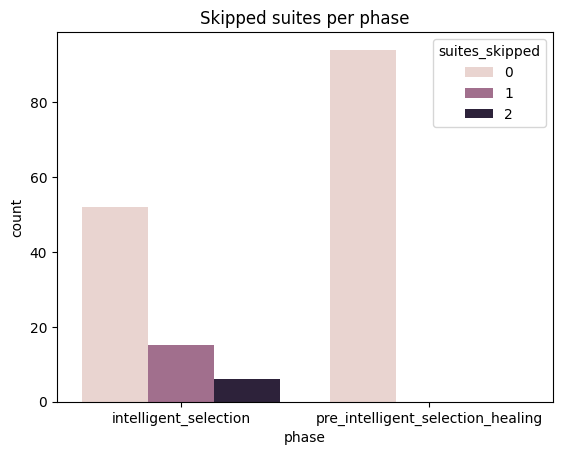

In [199]:
sns.countplot(x="phase", hue="suites_skipped", data=agg)
plt.title("Skipped suites per phase")

Text(0.5, 1.0, 'Suite outcomes by phase (pass/fail/skipped)')

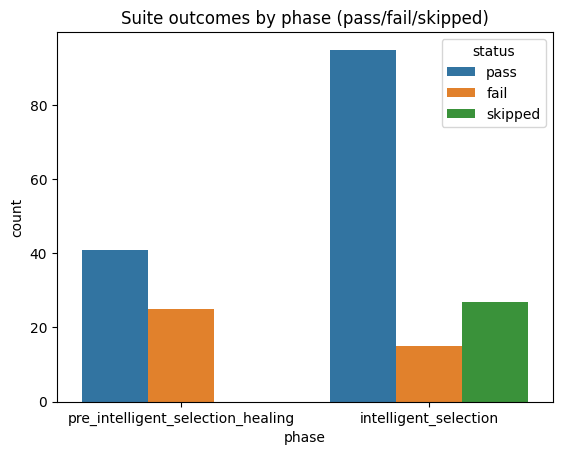

In [200]:
# Only look at unit/functional rows
suites = df[df["tag"].isin(["unit","functional"])]

sns.countplot(x="phase", hue="status", data=suites)
plt.title("Suite outcomes by phase (pass/fail/skipped)")

## 8. Time Saved vs Coverage

In [201]:
# Compute per-pipeline aggregates including skip counts

# Aggregate per pipeline
agg = (
    suites.groupby(["phase","pipeline_id"])
    .apply(lambda g: pd.Series({
        "minutes": g.loc[g["status"]!="skipped","duration_s"].sum()/60,
        "suites_run": (g["status"]!="skipped").sum(),
        "suites_skipped": (g["status"]=="skipped").sum(),
        "detected_fail": (g["status"]=="fail").any()
    }))
    .reset_index()
)

agg.head()

C:\Users\ehiva\AppData\Local\Temp\ipykernel_48172\997173533.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,phase,pipeline_id,minutes,suites_run,suites_skipped,detected_fail
0,intelligent_selection,1997439219,0.066833,1,0,False
1,intelligent_selection,1997481162,0.133667,1,0,True
2,intelligent_selection,1997508403,0.075167,1,0,False
3,intelligent_selection,1997553750,0.066833,1,0,False
4,intelligent_selection,2001049716,0.075167,1,0,False


In [202]:
# Summary by phase

summary = agg.groupby("phase").agg(
    avg_minutes=("minutes","mean"),
    avg_suites_run=("suites_run","mean"),
    avg_suites_skipped=("suites_skipped","mean"),
    detection_rate=("detected_fail","mean"),
    n_pipelines=("pipeline_id","count")
).reset_index()

summary

,phase,avg_minutes,avg_suites_run,avg_suites_skipped,detection_rate,n_pipelines
0,intelligent_selection,0.226127,1.527778,0.375,0.208333,72
1,pre_intelligent_selection_healing,0.239042,1.178571,0.000,0.446429,56


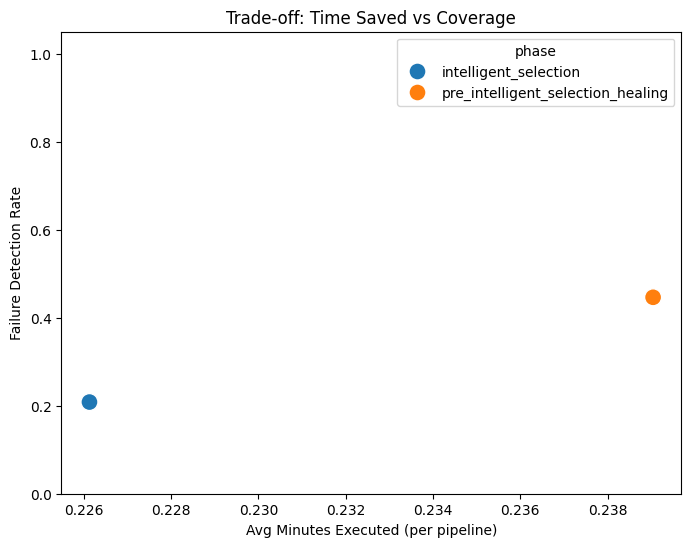

In [204]:
# Plot Time Saved vs Coverage

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=summary,
    x="avg_minutes", 
    y="detection_rate", 
    hue="phase", s=150
)
plt.xlabel("Avg Minutes Executed (per pipeline)")
plt.ylabel("Failure Detection Rate")
plt.title("Trade-off: Time Saved vs Coverage")
plt.ylim(0,1.05)
plt.show()

In [205]:
# Breakdown by mode (Suite vs Budget)

if "label" in df.columns:
    suites2 = df[df["tag"].isin(["unit","functional"])]
    agg2 = suites2.groupby(["label","pipeline_id"]).apply(lambda g: pd.Series({
        "minutes": g.loc[g["status"]!="skipped","duration_s"].sum()/60,
        "suites_skipped": (g["status"]=="skipped").sum(),
        "detected_fail": (g["status"]=="fail").any()
    })).reset_index()

    summary2 = agg2.groupby("label").mean(numeric_only=True).reset_index()
    display(summary2)


## NORMALISATION OF DATASET

In [ ]:
import pandas as pd

def normalize_suites(df):
    """
    Collapse multiple rows of 'unit' (collectstatic, migrate, unit-tests, retries)
    and 'functional' (if split) into ONE row per (pipeline_id, tag, mode).
    Non-test rows (build, lint, etc.) are preserved.
    Keeps row order by timestamp.
    """
    test_tags = ["unit", "functional"]

    # Separate suites vs other jobs
    test_df = df[df["tag"].isin(test_tags)].copy()
    other_df = df[~df["tag"].isin(test_tags)].copy()

    if test_df.empty:
        return df.sort_values("timestamp")

    # Aggregate per pipeline_id + tag + mode
    agg_test = (
        test_df.groupby(["pipeline_id","tag","mode"]).agg({
            "duration_s": "sum",    # total duration of all sub-steps
            "cpu_pct_avg": "mean",  # average CPU usage
            "mem_kb_max": "max",    # peak memory
            "exit_code": "max",     # any nonzero -> fail
            "status": lambda s: (
                "fail" if (s=="fail").any()
                else "skipped" if (s=="skipped").any()
                else "pass"
            ),
            "timestamp": "min",     # earliest timestamp among sub-steps
            "command": lambda s: ";".join(s)  # join commands for traceability
        }).reset_index()
    )

    # Merge back
    merged = pd.concat([other_df, agg_test], ignore_index=True)

    # Ensure chronological order
    merged = merged.sort_values(["pipeline_id","timestamp"]).reset_index(drop=True)

    return merged

df = pd.read_csv("intelligent_test_selection_pre_norm.csv")
df_norm = normalize_suites(df)

print("Before:", df.shape, "After normalization:", df_norm.shape)
df_norm.head(15)

# df_norm.to_csv("intelligent_test_selection.csv", index=False)


Before: (191, 10) After normalization: (146, 10)


In [142]:
import pandas as pd

df = pd.read_csv("all_logs_pre_norm.csv")

# Step 1: Map test tags
def map_tag(row):
    if row["tag"] == "test":
        cmd = row["command"]
        if "--exclude-tag=functional" in cmd:
            return "unit"
        elif "--tag=functional" in cmd:
            return "functional"
        elif "collectstatic" in cmd or "migrate" in cmd:
            return "unit"
    return row["tag"]

df["tag"] = df.apply(map_tag, axis=1)

# Step 2: Split into test vs non-test
test_df = df[df["tag"].isin(["unit","functional"])].copy()
non_test_df = df[~df["tag"].isin(["unit","functional"])].copy()

# Step 3: Aggregate only test jobs
agg_test = (test_df.groupby(["pipeline_id","tag","mode"])
         .agg({
             "timestamp":"first",
             "command": lambda x: ";".join(x),
             "duration_s":"sum",
             "exit_code":"max",
             "cpu_pct_avg":"mean",
             "mem_kb_max":"max",
             "status": lambda x: "fail" if "fail" in x.values else "pass"
         })
         .reset_index())

# Step 4: Reorder columns
agg_test = agg_test[["timestamp","command","duration_s","exit_code",
                     "cpu_pct_avg","mem_kb_max","tag","status","pipeline_id","mode"]]

non_test_df = non_test_df[["timestamp","command","duration_s","exit_code",
                           "cpu_pct_avg","mem_kb_max","tag","status","pipeline_id","mode"]]

# Step 5: Merge back together
normalized = pd.concat([non_test_df, agg_test]).sort_values(by=["timestamp"]).reset_index(drop=True)

# normalized.to_csv("all_logs.csv", index=False)
print("Before:", df.shape, "After:", normalized.shape)


Before: (606, 10) After: (427, 10)


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("all_logs.csv")

# Count before
before = len(df)

# Drop duplicates
df = df.drop_duplicates()

# Count after
after = len(df)

print(f"Rows before: {before}")
print(f"Rows after : {after}")
print(f"Removed    : {before - after}")

# Save back (optional)
# df.to_csv("all_logs.csv", index=False)

Rows before: 271
Rows after : 271
Removed    : 0


In [ ]:
df2 = pd.read_csv("intelligent_test_selection.csv")
print("Before:", len(df2))
df2 = df2.drop_duplicates()
print("After :", len(df2))
print("Removed:", len(df2))
# df2.to_csv("intelligent_test_selection.csv", index=False)
